In [2]:
import pandas as pd
import afqinsight as afq
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from groupyr.transform import GroupExtractor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import sklearn.metrics

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

In [4]:
X, y, groups, feature_names, group_names, subjects, _ = afq.datasets.load_afq_data('../data/raw/age_data', "Age")

In [5]:
group_extractor = GroupExtractor(select=['fa', 'md'], groups=groups, group_names=group_names)
X = group_extractor.fit_transform(X)

In [6]:
#group_names = [g for g in group_names if g[0] in ['md', 'fa']]
#print(len(group_names))
#print(X.shape)
#groups = groups[0:40]
#group_extractor = GroupExtractor(select=['Right Cingulum Cingulate'], groups=groups, group_names=group_names)
#X = group_extractor.fit_transform(X)

In [7]:
X.shape

(77, 4000)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57, 4000), (57,), (20, 4000), (20,))

In [11]:
X_train_reshaped = np.swapaxes(X_train.reshape((57, 40, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((20, 40, 100)), 1, 2)

In [32]:
model = Sequential()

# input: 3+D tensor with shape: batch_shape + (steps, input_dim)
# output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=X_train_reshaped.shape[1:]))
model.add(Conv1D(24, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(128, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(256, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100, 128)          5248      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 99, 24)            6168      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 50, 24)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 49, 32)            1568      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 23, 64)            6208      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 12, 64)           

In [42]:
callback = EarlyStopping(monitor='loss', patience=10)
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=100, validation_data=(X_test_reshaped, y_test), callbacks=callback)
loss_and_metrics = model.evaluate(X_test_reshaped, y_test, batch_size=100)
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Epoch 1/100
1/1 [==============================] - 0s 144ms/step - loss: 78.1683 - mean_squared_error: 78.1683 - val_loss: 74.3070 - val_mean_squared_error: 74.3070
Epoch 2/100
1/1 [==============================] - 0s 99ms/step - loss: 77.9382 - mean_squared_error: 77.9382 - val_loss: 73.9823 - val_mean_squared_error: 73.9823
Epoch 3/100
1/1 [==============================] - 0s 83ms/step - loss: 74.5444 - mean_squared_error: 74.5444 - val_loss: 78.0838 - val_mean_squared_error: 78.0838
Epoch 4/100
1/1 [==============================] - 0s 92ms/step - loss: 85.2304 - mean_squared_error: 85.2304 - val_loss: 72.9201 - val_mean_squared_error: 72.9201
Epoch 5/100
1/1 [==============================] - 0s 99ms/step - loss: 74.9806 - mean_squared_error: 74.9806 - val_loss: 74.7528 - val_mean_squared_error: 74.7528
Epoch 6/100
1/1 [==============================] - 0s 90ms/step - loss: 74.9208 - mean_squared_error: 74.9208 - val_loss: 76.8660 - val_mean_squared_error: 76.8660
Epoch 7/100
1/1

In [43]:
import matplotlib.pyplot as plt

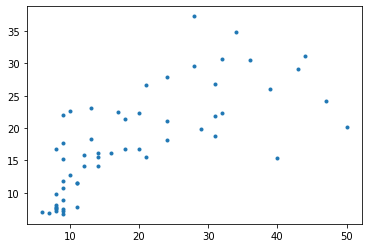

In [44]:
y_hat = model.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")

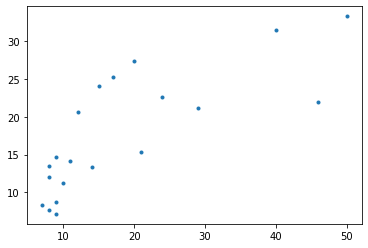

In [45]:
y_hat = model.predict(X_test_reshaped)
plt.plot(y_test, y_hat, linestyle="", marker=".")

In [46]:
from sklearn.metrics import r2_score

In [47]:
r2_score(y_test, y_hat)

0.5747224272211304